In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
churn = pd.read_csv('telecom_churn.csv', skipinitialspace=True)
churn.head()

,subscriberID,churn,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10000
0,19164958,1,0,20,2,12,16,0,113.666667,-8.0,0,1,0,0,1,1,0,0,0,0
1,39244924,1,1,20,0,21,5,0,274.000000,-371.0,0,1,2,1,3,2,2,1,0,1
2,39578413,1,0,11,1,47,3,0,392.000000,-784.0,0,1,0,0,3,3,0,0,0,1
3,40992265,1,0,43,0,4,12,0,31.000000,-76.0,0,1,2,1,3,3,0,0,0,1
4,43061957,1,1,60,0,9,14,0,129.333333,-334.0,0,1,0,0,3,3,0,0,0,0


划分训练集和测试集

In [3]:
from sklearn.model_selection import train_test_split

data = churn.iloc[:, 2:]
target = churn['churn']
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.4, train_size=0.6, random_state=123) 

极差标准化

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data)

scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,), 
                    activation='logistic', alpha=0.1, max_iter=1000)

mlp.fit(scaled_train_data, train_target)
mlp

MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

### 预测

预测分类标签

In [18]:
train_predict = mlp.predict(scaled_train_data)
test_predict = mlp.predict(scaled_test_data)

预测概率

In [7]:
# 计算分别属于各类的概率，取标签为1的概率
train_proba = mlp.predict_proba(scaled_train_data)[:, 1]  
test_proba = mlp.predict_proba(scaled_test_data)[:, 1]

### 验证

In [8]:
from sklearn import metrics

print(metrics.confusion_matrix(test_target, test_predict, labels=[0, 1]))
print(metrics.classification_report(test_target, test_predict))

[[671 130]
 [ 99 486]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       801
           1       0.79      0.83      0.81       585

    accuracy                           0.83      1386
   macro avg       0.83      0.83      0.83      1386
weighted avg       0.84      0.83      0.84      1386



In [9]:
mlp.score(scaled_test_data, test_target) # Mean accuracy

0.8347763347763347

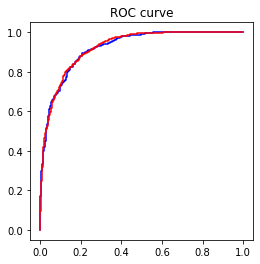

AUC = 0.9217


In [10]:
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_proba)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_proba)

plt.figure(figsize=[4, 4])
plt.plot(fpr_test, tpr_test, 'b-')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()

print('AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

param_grid = {
    'hidden_layer_sizes':[(10, ), (15, ), (20, ), (5, 5)],
    'activation':['logistic', 'tanh', 'relu'], 
    'alpha':[0.001, 0.01, 0.1, 0.2, 0.4, 1, 10]
}
mlp = MLPClassifier(max_iter=1000)
gcv = GridSearchCV(estimator=mlp, param_grid=param_grid, 
                   scoring='roc_auc', cv=4, n_jobs=-1)
gcv.fit(scaled_train_data, train_target)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=1000,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu']

In [12]:
gcv.best_score_

0.9225786562748618

In [13]:
gcv.best_params_

{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (20,)}

In [14]:
gcv.best_estimator_

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [15]:
gcv.score(scaled_test_data, test_target) # Mean accuracy

0.9222851777158892